In [28]:
import pm4py
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pickle
import numpy as np
import tqdm
import seaborn as sns
from project_functions import *

Load dataset with pickle

In [29]:
log = None
with open("data/log_pm4py.pkl", "rb") as f:
    log = pickle.load(f)
log_df = pm4py.convert_to_dataframe(log)


# Initial activities:
* Renaming columns
* Counting activities and cases
* Identifying start and end activities 
* Number of missing value for each column

In [30]:
num_events = len(log_df)
num_cases = len(log_df['case:concept:name'].unique())

start_activities = pm4py.get_start_activities(log_df)
end_activities = pm4py.get_end_activities(log_df)

print("Number of events: ", num_events)
print("Number of cases: ", num_cases)
print("Start activities: ", start_activities)
print("End activities: ", end_activities)

missing_counts = log_df.isnull().sum()
print('Count missing values in each column: ')
print(missing_counts)

Number of events:  561470
Number of cases:  150370
Start activities:  {'Create Fine': 150370}
End activities:  {'Send Fine': 20755, 'Send for Credit Collection': 58997, 'Payment': 67201, 'Send Appeal to Prefecture': 3144, 'Appeal to Judge': 134, 'Notify Result Appeal to Offender': 86, 'Receive Result Appeal from Prefecture': 53}
Count missing values in each column: 
amount                  331240
org:resource            410545
dismissal               406404
concept:name                 0
vehicleClass            411100
totalPaymentAmount      333499
lifecycle:transition         0
time:timestamp               0
article                 411100
points                  411100
case:concept:name            0
expense                 457483
notificationType        481610
lastSent                483241
paymentAmount           483869
matricola               560915
dtype: int64


# Find which columns are related to the activities

In [31]:
#for each activity, get the non nan attributes
activity_attributes = {}
for activity in log_df["concept:name"].unique():
    activity_attributes[activity] = set(log_df[log_df["concept:name"] == activity].dropna(axis=1, how='all' ).columns)

common_activity_attributes = set.intersection(*activity_attributes.values())


#remove the common attributes from the event attributes
for activity in activity_attributes:
    activity_attributes[activity] = activity_attributes[activity] - common_activity_attributes
    

print(f"Attributes writes by each activity: {common_activity_attributes}")
print('='*35)
print()
for activity in activity_attributes:
    print(f"Attributes writes by {activity}: {activity_attributes[activity]}")
    print(' '*21+'-'*len(activity))

    

Attributes writes by each activity: {'case:concept:name', 'concept:name', 'time:timestamp', 'lifecycle:transition'}

Attributes writes by Create Fine: {'vehicleClass', 'org:resource', 'article', 'amount', 'points', 'totalPaymentAmount', 'dismissal'}
                     -----------
Attributes writes by Send Fine: {'expense'}
                     ---------
Attributes writes by Insert Fine Notification: {'notificationType', 'lastSent'}
                     ------------------------
Attributes writes by Add penalty: {'amount'}
                     -----------
Attributes writes by Send for Credit Collection: set()
                     --------------------------
Attributes writes by Payment: {'totalPaymentAmount', 'paymentAmount'}
                     -------
Attributes writes by Insert Date Appeal to Prefecture: set()
                     --------------------------------
Attributes writes by Send Appeal to Prefecture: {'dismissal'}
                     -------------------------
Attributes w

In [32]:
all_activity_attributes = {}
for activity in log_df["concept:name"].unique():
    all_activity_attributes[activity] = set(log_df[log_df["concept:name"] == activity].dropna(axis=1, how='all' ).columns)
    
any_activity_attributes = {}
for activity in log_df["concept:name"].unique():
    any_activity_attributes[activity] = set(log_df[log_df["concept:name"] == activity].dropna(axis=1, how='any' ).columns)
    
if (all_activity_attributes == any_activity_attributes):
    print("There are no missing values in the attribtues")
else:
    for activity in all_activity_attributes:
        missing_values = all_activity_attributes[activity] - any_activity_attributes[activity]
        if(len(missing_values) > 0):
            print(f"Missing values for activity {activity}: {missing_values}")

Missing values for activity Insert Fine Notification: {'lastSent'}


The only incongruence in the log when it comes to attibutes edited by activities, is on the column lastSent which is not in our interest; so we can procede with the guarantee of having no errors from this point of view.

# Activities frequencies

/Users/alessandro/Documents/Universita/Business_Information_System/Progetto_BIS/Progetto/project_functions.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


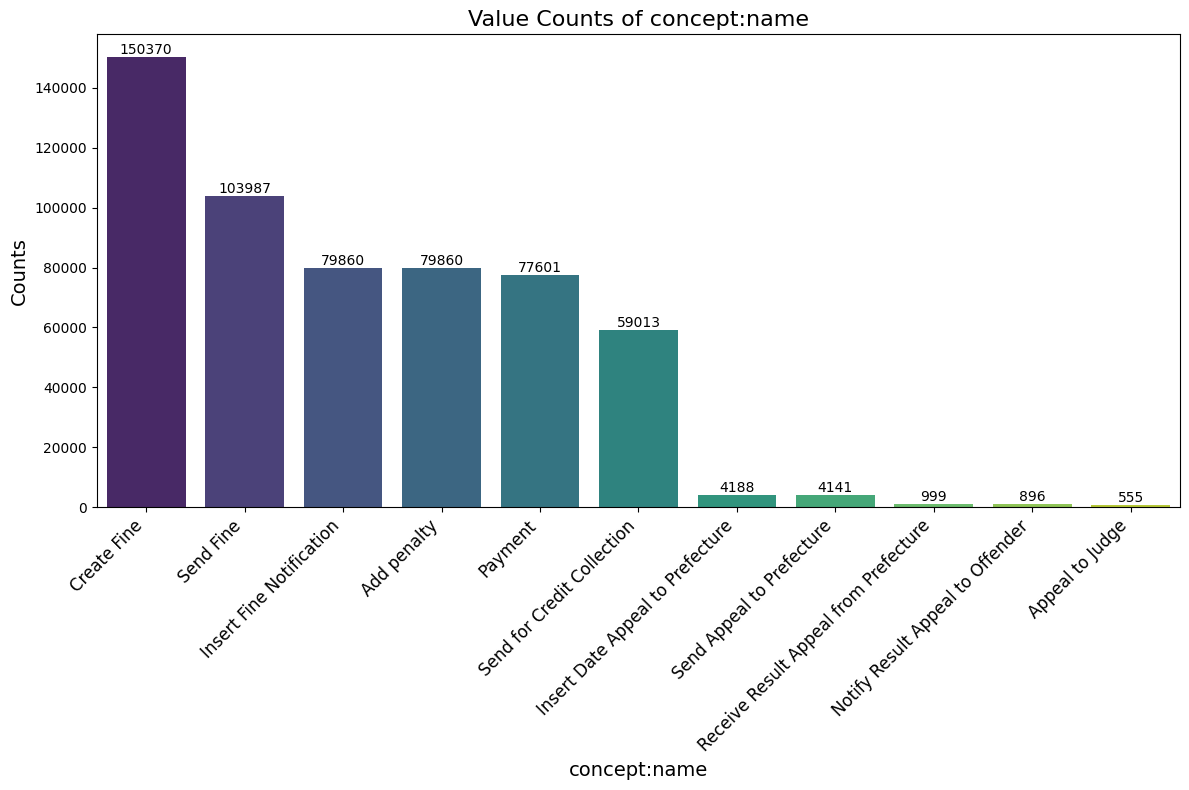

In [37]:

plot_value_counts(log_df, "concept:name", img_path="img/concept_name_value_counts.png")

Just by looking at this chart we can notice that there are some problem with the end activities: ideally the only way to end a case is with 'Payment' or with 'Send for credit collection', but just by summing those value we are about 15k cases under the number of activities (which are the same number of 'Create Fine'). We will later analyze this problem with variant analysis and with some constraint injection.

# General Knowledge on data

In this section we try to extract some knowledge from the dataset that we may be helpful later.

## Fine and article relation

In [34]:
df = log_df.dropna(subset=['article', 'amount'])

# Raggruppare i dati per 'article' e ottenere tutti gli 'amount' associati come set
article_amount_dict = df.groupby('article')['amount'].apply(lambda x: set(x)).to_dict()


article_amount_dict

{7.0: {0.0,
  18.78,
  19.0,
  19.68,
  19.95,
  21.0,
  22.0,
  23.0,
  24.0,
  25.0,
  31.3,
  32.0,
  32.8,
  33.6,
  35.0,
  36.0,
  37.56,
  38.0,
  39.0,
  39.35,
  39.9,
  41.0,
  56.34,
  59.03,
  62.59,
  65.0,
  65.6,
  68.0,
  68.25,
  70.0,
  71.0,
  74.0,
  76.0,
  78.0,
  80.0,
  98.4,
  652.0},
 15.0: {22.0, 24.0, 32.8, 35.0, 39.0},
 20.0: {131.0, 131.2, 137.55, 143.0, 148.0, 155.0, 159.0},
 21.0: {655.0, 655.99, 687.75, 716.0, 742.0},
 23.0: {312.97,
  327.0,
  328.0,
  343.35,
  357.0,
  370.0,
  389.0,
  398.0,
  4000.0,
  4351.0},
 29.0: {155.0, 159.0},
 40.0: {0.0, 31.3, 33.6, 38.0, 39.0},
 41.0: {0.0, 62.59, 65.0, 65.6, 68.25, 137.55},
 43.0: {0.0, 31.3, 32.0, 32.8, 33.6, 62.59, 65.0, 65.6},
 61.0: {327.0},
 64.0: {80.0},
 68.0: {19.68},
 71.0: {71.0},
 72.0: {62.59, 65.0, 68.25, 71.0, 78.0},
 79.0: {71.0},
 80.0: {125.19,
  131.0,
  131.2,
  137.55,
  143.0,
  148.0,
  155.0,
  159.0,
  168.0,
  262.0,
  262.39,
  275.1,
  286.0,
  296.0,
  310.0,
  318.0,
  1842.

We can see that for each article the amount can vary.

## Article frequency

/var/folders/_f/k63ns_v15qv4kfpd87ckc8lm0000gn/T/ipykernel_56201/3708441045.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['article'] = df['article'].astype(str)
/var/folders/_f/k63ns_v15qv4kfpd87ckc8lm0000gn/T/ipykernel_56201/3708441045.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='article', y='frequency', data=filtered_article_frequency, palette='viridis')


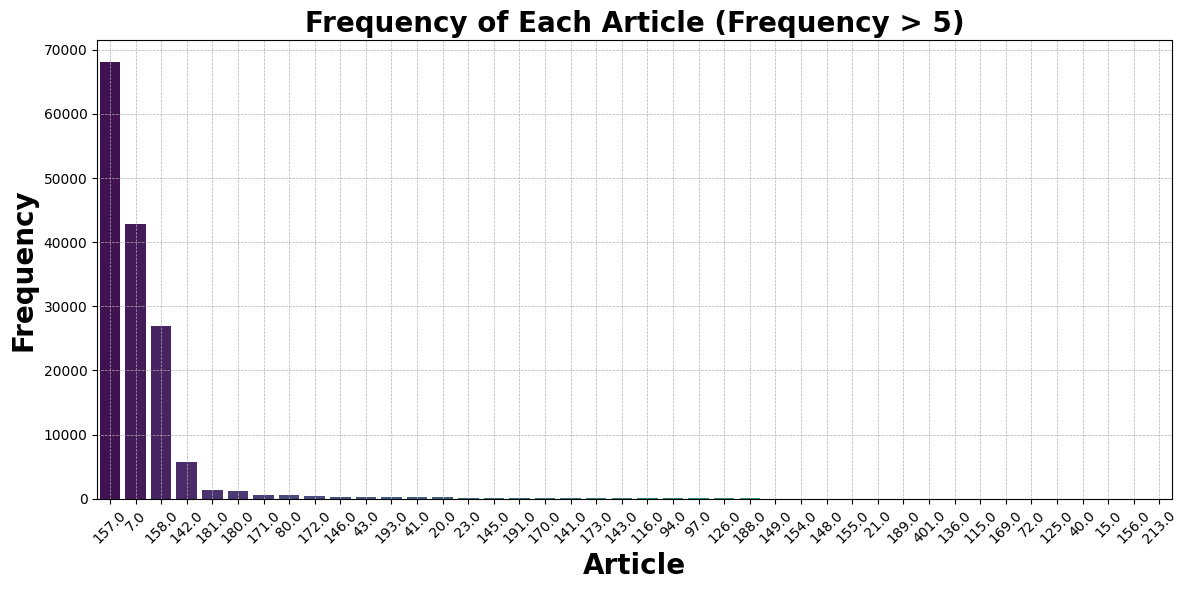

Number of discarded cases: 24


In [35]:
df['article'] = df['article'].astype(str)

# Calcolare la frequenza di ciascun 'article'
article_frequency = df['article'].value_counts().reset_index()
article_frequency.columns = ['article', 'frequency']

# Filtrare gli articoli con frequenza >= 50
filtered_article_frequency = article_frequency[article_frequency['frequency'] > 5]

discarderd_articles = len(article_frequency[article_frequency['frequency'] <= 5])


# Creare l'istogramma
plt.figure(figsize=(12, 6))
sns.barplot(x='article', y='frequency', data=filtered_article_frequency, palette='viridis')

plt.xlabel('Article', fontsize=20, weight='bold')
plt.ylabel('Frequency', fontsize=20,weight='bold')
plt.title('Frequency of Each Article (Frequency > 5)', fontsize=20, weight='bold')
plt.xticks(rotation=45)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

print(f"Number of omitted cases: {discarderd_articles}")

We can see that most of the cases are related to three specific articles. This three article (157, 158 and 7) are applied in a situation when a veichle is parked in a place where is prohibited